In [1]:
import torch
from torch.utils.data import DataLoader

from levee_hunter.plots import plot_training_validation_loss
from levee_hunter.segmentation_dataset import SegmentationDataset
from levee_hunter.utils import count_parameters
from levee_hunter.plots import infer_and_visualize
from levee_hunter.train_test_split_dataset import train_test_split_dataset
from levee_hunter.modeling.train import train_model
import numpy as np
import segmentation_models_pytorch as smp

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:20: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/pmucha/fathom/levee-hu

In [2]:
# Load the datasets
train_test_dataset = torch.load(
    "../data/intermediate/1m_512/train_test.pth", weights_only=False
)
validation_dataset = torch.load(
    "../data/intermediate/1m_512/validation.pth", weights_only=False
)
bad_dataset = torch.load(
    "../data/intermediate/1m_512/bad.pth", weights_only=False
)

print(len(train_test_dataset))
print(len(validation_dataset))
print(len(bad_dataset))

824
196
213


In [3]:
train_test_dataset.modify_targets(mask_type='dilated', dilation_size=11)
validation_dataset.modify_targets(mask_type='dilated', dilation_size=11)
bad_dataset.modify_targets(mask_type='dilated', dilation_size=11)

training_dataset, test_dataset = train_test_split_dataset(train_test_dataset, test_size=0.115)

len(training_dataset), len(test_dataset)

(729, 95)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
val_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)

train_loader.dataset.images[0].shape, len(train_loader.dataset.images)

((1, 512, 512), 729)

In [5]:
model = smp.Segformer(
    encoder_name="mit_b1", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(torch.load("../models/w5_models/Segformer-1m_512.pth"))
model.eval()

validation_dataset.transform = 'z_score_normalize'
bad_dataset.transform = 'z_score_normalize'

In [6]:
training_dataset.transform, test_dataset.transform, validation_dataset.transform, bad_dataset.transform

('train_transform',
 'z_score_normalize',
 'z_score_normalize',
 'z_score_normalize')

In [7]:
from levee_hunter.modeling.infer import infer

for images, masks in test_loader:
    predictions = infer(model, image_tensor=images, device=device, apply_sigmoid=True, threshold=0.5)
predictions.shape

(95, 1, 512, 512)

In [16]:
# if there are batches in the DataLoader, we need to concatenate them:
all_preds = []
for images, masks in train_loader:
    predictions = infer(model, image_tensor=images, device=device, apply_sigmoid=True, threshold=0.5)
    all_preds.append(predictions)
all_preds = np.concatenate(all_preds, axis=0)
all_preds.shape

(729, 1, 512, 512)

0


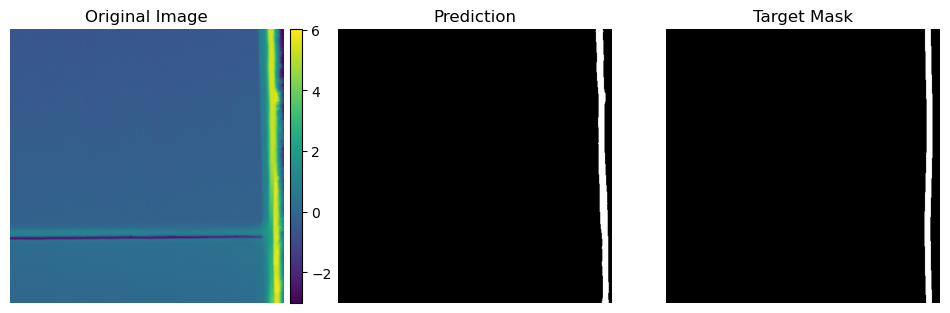

1


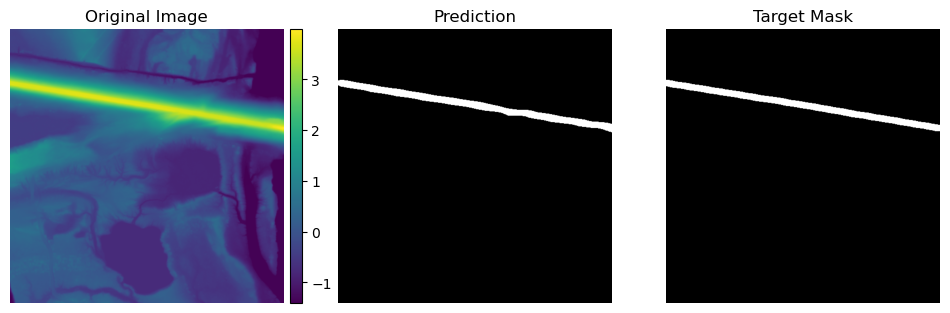

2


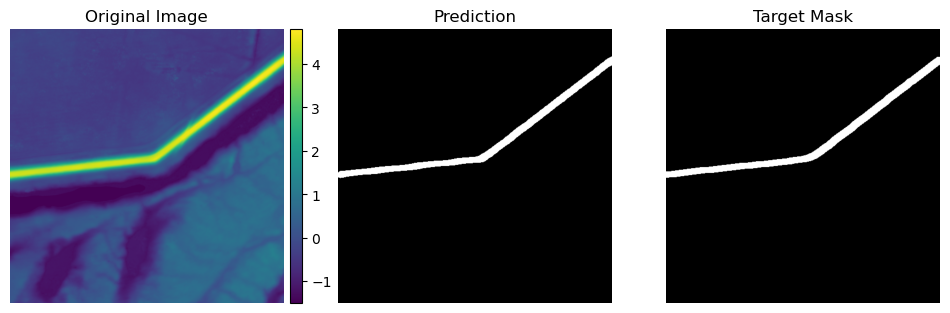

In [8]:
for ix in range(3):
    sample_image, sample_mask = test_dataset[ix]
    print(ix)
    pred = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)

In [9]:
from levee_hunter.plots import infer_and_plot_overlap

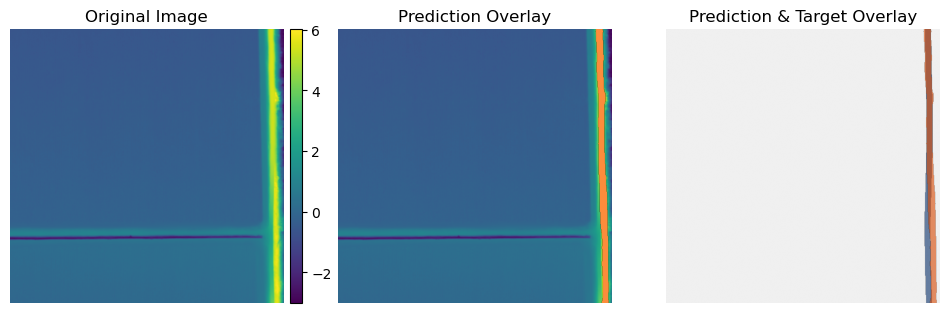

In [10]:
img, target = test_dataset[0]

output = infer_and_plot_overlap(
    model=model, 
    image_tensor=img, 
    mask_tensor=target, 
    device=device, apply_sigmoid=True, 
    threshold=0.5, 
    invert=True
    )

In [11]:
from levee_hunter.plots import plot_selected_pixels

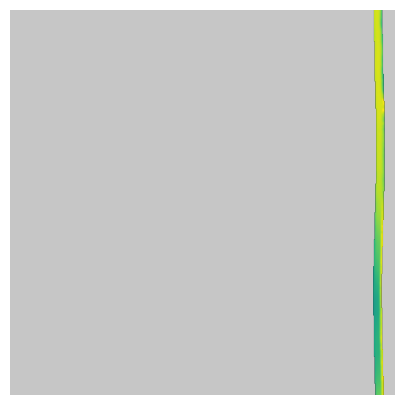

In [12]:
img, target = test_dataset[0]

plot_selected_pixels(original_img=img, pred_img=target, figsize=(5,5), invert=True)

In [13]:
output = infer(model, image_tensor=img, device=device, apply_sigmoid=True, threshold=0.5)
output.shape

(1, 512, 512)

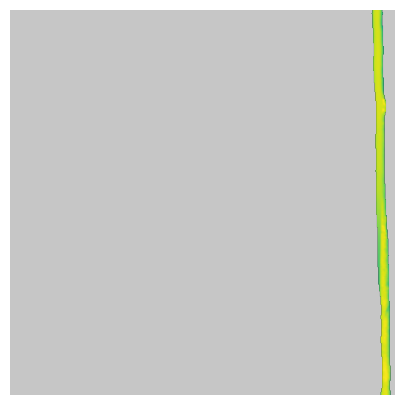

In [14]:
plot_selected_pixels(original_img=img, pred_img=output, figsize=(5,5), invert=True)